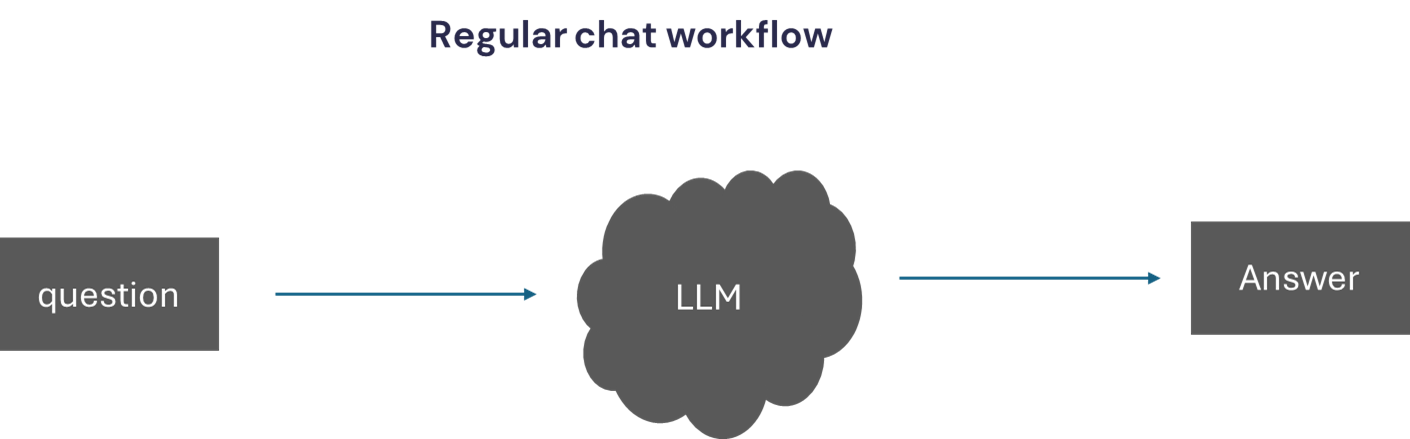

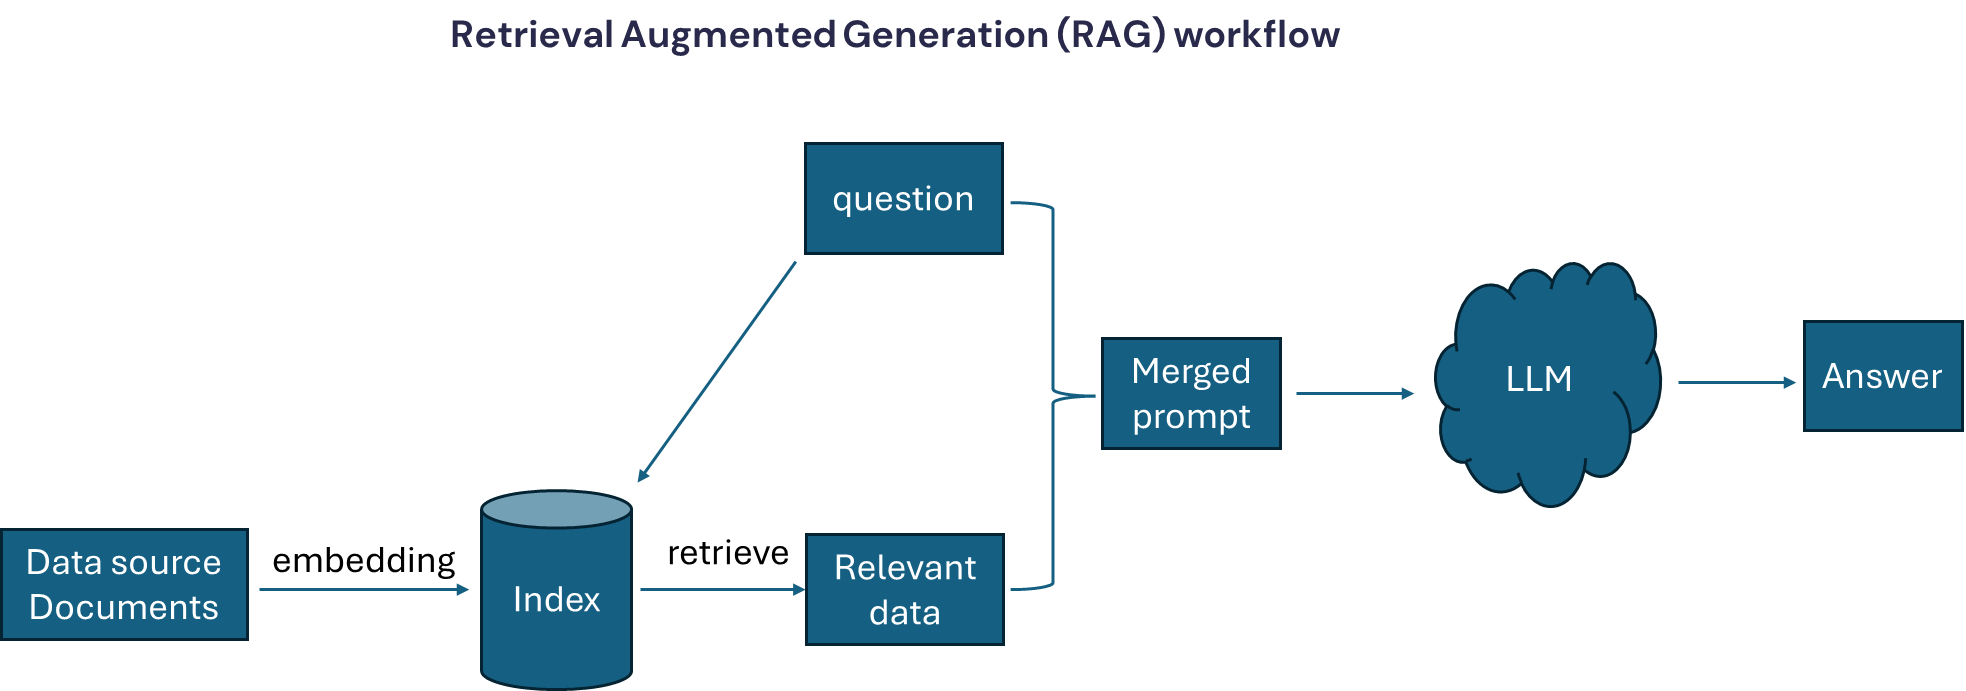

## Install all packages
Note: may install multiple times due to session restart requirement

In [1]:
!pip install openai

!pip install langchain
!pip install langchain-core
!pip install langchain-litellm
!pip install langchain-community

!pip install llama-index
!pip install llama-index-llms-langchain

# !pip install PyPDF2
!pip install PyCryptodome
!pip install gradio

  Using cached langchain_core-1.0.4-py3-none-any.whl.metadata (3.5 kB)
  Using cached langchain_text_splitters-1.0.0-py3-none-any.whl.metadata (2.6 kB)
Using cached langchain_core-1.0.4-py3-none-any.whl (471 kB)
Using cached langchain_text_splitters-1.0.0-py3-none-any.whl (33 kB)
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.79
    Uninstalling langchain-core-0.3.79:
      Successfully uninstalled langchain-core-0.3.79
  Attempting uninstall: langchain-text-splitters
    Found existing installation: langchain-text-splitters 0.3.11
    Uninstalling langchain-text-splitters-0.3.11:
      Successfully uninstalled langchain-text-splitters-0.3.11
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain-litellm 0.3.0 requires langchain-core<0.4.0,>=0.3.15, but you have langchain-core 1.0.4 which is incompatible.
langchain

## Get the API keys form Navigator toolkit

https://it.ufl.edu/ai/navigator-toolkit/

### Save the obtained API key to Colab's "Secrets"

You can use Colab's built-in "Secrets" feature to store sensitive information like API keys. These secrets are securely stored and can be accessed without directly editing a file.

* Navigate to the "Secrets" pane from the left navigation bar in Colab.
* Add a new secret with a name and value.
* Enable "Notebook access" for the current notebook.
* Access the secret using code:

`from google.colab import userdata`

`my_secret_value = userdata.get('secretName')`

In [40]:
from google.colab import userdata
import os

All_API_KEY = userdata.get('API_key')

# Set as the environment variable, for OpenAI to automatically detect keys
os.environ['OPENAI_API_KEY'] = All_API_KEY

### Check list of available models

In [41]:
import openai

# Check list of available models
client = openai.OpenAI(
    # api_key=All_API_KEY,
    base_url="https://api.ai.it.ufl.edu/"
)

response = client.models.list()

# Print available models in better format
for model in response:
    print(model.id)

llama-3.1-70b-instruct
llama-3.1-8b-instruct
llama-3.1-nemotron-nano-8B-v1
llama-3.3-70b-instruct
mistral-7b-instruct
mistral-small-3.1
codestral-22b
gemma-3-27b-it
gpt-oss-20b
gpt-oss-120b
granite-3.3-8b-instruct
sfr-embedding-mistral
nomic-embed-text-v1.5
flux.1-dev
flux.1-schnell
whisper-large-v3
kokoro


## download sample documents

In [29]:
import gdown
# The URL of the shared Google Drive folder
url = "https://drive.google.com/drive/folders/1zPL5hDzDsf5p9WgWF-4FLeBNu4B6DAod?usp=sharing"

# Download the folder to your current working directory
downloaded_file_paths = gdown.download_folder(url, quiet=True, use_cookies=False)

In [30]:
doc_path = os.path.dirname(downloaded_file_paths[0])
doc_path

'/content/docs_sap54'

## build the Chatbot with RAG

### 1. build index

#### 1.1 customize the embedding class

In [42]:
from llama_index.core.embeddings import BaseEmbedding
from typing import List
import asyncio, httpx

class SFRMistralEmbedding(BaseEmbedding):
    def __init__(self, model_name: str, api_base: str, api_key: str, **kwargs):
        super().__init__(**kwargs)
        self._model_name = model_name
        self._api_base = api_base.rstrip("/")
        self._api_key = api_key
        self._headers = {
            "Authorization": f"Bearer {self._api_key}",
            "Content-Type": "application/json"
        }

    def _get_embedding(self, text: str) -> List[float]:
        payload = {
            "model": self._model_name,
            "input": [text]
        }
        response = httpx.post(f"{self._api_base}/embeddings", json=payload, headers=self._headers)
        response.raise_for_status()
        return response.json()["data"][0]["embedding"]

    def _get_query_embedding(self, query: str) -> List[float]:
        return self._get_embedding(query)

    def _get_text_embedding(self, text: str) -> List[float]:
        return self._get_embedding(text)

    async def _aget_query_embedding(self, query: str) -> List[float]:
        loop = asyncio.get_event_loop()
        return await loop.run_in_executor(None, self._get_query_embedding, query)

    def get_text_embedding(self, text: str) -> List[float]:
        return self._get_text_embedding(text)

    def get_query_embedding(self, query: str) -> List[float]:
        return self._get_query_embedding(query)


#### 1.2 specify embedding model

In [43]:
from llama_index.core import SimpleDirectoryReader, VectorStoreIndex, Settings, PromptHelper
from llama_index.llms.langchain import LangChainLLM
from llama_index.core.llms import LLMMetadata
from langchain_litellm import ChatLiteLLM # langchain.chat_models' ChatOpenAI not allow customize models
import gradio as gr

# use the created customized embedding model
embed_model = SFRMistralEmbedding(
    model_name="sfr-embedding-mistral", # nomic-embed-text-v1.5
    api_base="https://api.ai.it.ufl.edu/",
    api_key=os.environ['OPENAI_API_KEY']
)

# Prompt configuration
prompt_helper = PromptHelper(
    context_window=4096, # The maximum input prompt (context + query + instructions) tokens the LLM can handle
    num_output=512, # Maximum number of tokens in the model’s answer.
    chunk_overlap_ratio=0.1,
    chunk_size_limit=600 # documents are broken into chunks of up to 600 tokens before embedding.
)

# set the default LLM and embeding models for llama_index
Settings.embed_model = embed_model
Settings.prompt_helper = prompt_helper


#### 1.3 define a function to build index

In [44]:
from llama_index.core import StorageContext, load_index_from_storage

def construct_index(directory_path):

    # Load documents from the specified directory into memory
    documents = SimpleDirectoryReader(directory_path).load_data()

    # VectorStoreIndex converts each document into embeddings (using the registered embed_model)
    # and stores them in a vector database for semantic search and retrieval
    index = VectorStoreIndex.from_documents(documents)

    # Persist the index to disk for later reuse
    index.storage_context.persist(persist_dir="./index_storage")

    return index


#### 1.4 (optional): what's retrived?

In [45]:
index = construct_index(doc_path)

query = "What are the key features of SAP54?"
retrieved_nodes = index.as_retriever().retrieve(query)

context = "\n".join([n.node.get_content() for n in retrieved_nodes])
print(context)

stamens are produced in the third whorl, and two
fused carpels arise from the central fourth whorl to
form the gynoecium, which houses the ovules. In
comparison with the wild-type plants, the sepals of
35S::SAP54 line 4 were larger and did not enclose the
petals but rather curled outward and away from the
petals, a trait that was also observed in ﬂowers of AY-
WB-infected plants (Figs. 1, E and G, and 3B). Scan-
ning electron microscopy revealed that the sepals of
SAP54-expressing and infected plants are composed of
irregular, interlocking cells that are more reminiscent
of leaf pavement cells than the elongated cells that
constitute the sepals of wild-type (healthy) Col-0 (Fig.
4A). The hypertrophic sepals of the transgenic line
assumed an increasingly leaf-like appearance as the
ﬂower aged. White petals were occasionally present
in newly opened ﬂowers of 35S::SAP54 line 4 plants,
but these either dropped from the plant or reverted
to green leaf-like tissues as the ﬂower matured. An
i

In [46]:
# Ready-to-run snippet for inspecting context + merged prompt

def inspect_prompt(index, query: str):
    # Step 1: Retrieve relevant nodes
    retrieved_nodes = index.as_retriever().retrieve(query)

    print("=== Retrieved Context Chunks ===")
    for i, node in enumerate(retrieved_nodes, start=1):
        print(f"\n--- Chunk {i} ---")
        print(node.node.get_content())

    # Step 2: Build merged prompt manually
    context = "\n".join([n.node.get_content() for n in retrieved_nodes])
    merged_prompt = f"""
You are a helpful assistant. Use the following context to answer the question.
If the answer is not contained in the context, say you don’t know.

Context:
{context}

Question:
{query}

Answer:
"""
    print("\n=== Final Merged Prompt ===")
    print(merged_prompt)


# Example usage:
query = "What are the key features of SAP54?"
inspect_prompt(index, query)


=== Retrieved Context Chunks ===

--- Chunk 1 ---
stamens are produced in the third whorl, and two
fused carpels arise from the central fourth whorl to
form the gynoecium, which houses the ovules. In
comparison with the wild-type plants, the sepals of
35S::SAP54 line 4 were larger and did not enclose the
petals but rather curled outward and away from the
petals, a trait that was also observed in ﬂowers of AY-
WB-infected plants (Figs. 1, E and G, and 3B). Scan-
ning electron microscopy revealed that the sepals of
SAP54-expressing and infected plants are composed of
irregular, interlocking cells that are more reminiscent
of leaf pavement cells than the elongated cells that
constitute the sepals of wild-type (healthy) Col-0 (Fig.
4A). The hypertrophic sepals of the transgenic line
assumed an increasingly leaf-like appearance as the
ﬂower aged. White petals were occasionally present
in newly opened ﬂowers of 35S::SAP54 line 4 plants,
but these either dropped from the plant or reverted
to 

### 2. build LLM

In [47]:
# Define Chat Model and Metadata via UF LiteLLM proxy
chat_model = ChatLiteLLM(
    model="llama-3.3-70b-instruct", # gpt-oss-120b, llama-3.3-70b-instruct
    api_base="https://api.ai.it.ufl.edu/",
    # api_key=os.environ['OPENAI_API_KEY'],
    temperature=0.7, # range 0-2. Lower values: more precise, repeatable answers. Higher values: more imaginative, but less reliable.
    max_tokens=512,
    custom_llm_provider="openai"
)

# Create LangChainLLM without metadata
llm = LangChainLLM(llm=chat_model)

# Patch metadata directly into the instance
llm.__dict__["metadata"] = LLMMetadata(
    context_window=4096,
    num_output=512,
    is_chat_model=True,
    model_name="llama-3.3-70b-instruct"
)


# set the default LLM for llama_index
Settings.llm = llm
Settings.prompt_helper = prompt_helper

### 3. build chatbot

In [48]:
# Query function
def chatbot(input_text):

    # Load the saved embeddings and metadata from the "./index_storage" directory
    storage_context = StorageContext.from_defaults(persist_dir="./index_storage")

    # Load the index from the storage context, without rebuilding from documents
    index = load_index_from_storage(storage_context)

    # Create a query engine from the index
    # The query_engine handles retrieval + response generation
    # response_mode="compact" means answers will be concise rather than verbose
    query_engine = index.as_query_engine(response_mode="compact")

    # Run a query against the index
    # This takes the user input, retrieves relevant context from the index,
    # merges it into a prompt, and sends it to the LLM for an answer
    response = query_engine.query(input_text)

    return str(response)

In [49]:
# Gradio interface
iface = gr.Interface(
    fn=chatbot,
    inputs=gr.Textbox(lines=7, label="Enter your text"),
    outputs=gr.Textbox(lines=8,label="text"),
    title="Custom-trained AI Chatbot"
)

# lauch the interface
iface.launch(share=True, debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://f416761da72a7139ab.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://f416761da72a7139ab.gradio.live
